# Flexible representation of quantum images - [FRQI](https://link.springer.com/content/pdf/10.1007/s11128-010-0177-y.pdf)

**with custom image as input**

## Representation equation $| I(\theta)\rangle = \frac{1}{2^n}\sum_{i=0}^{2^{2n}-1}(cos\theta_i | 0 \rangle + sin\theta_i | 1 \rangle) \otimes | i \rangle$, where

$\theta_i$ - continuous representation of the inensity,

$i$ - binary expansion of the pixel coordinate.

Step 0: dependencies import

In [1]:
from qiskit import QuantumRegister, ClassicalRegister
from qiskit import QuantumCircuit
from qiskit import transpile, assemble, transpiler
from qiskit.visualization import plot_histogram
from qiskit_aer import Aer
import matplotlib.pyplot as plt
import numpy as np
import math
from ibm_washington_config import coupling_map, basis_gates
from ionq_config import coupling_map, basis_gates
#TODO put image_utils in helpers/ -> ISSUE: I don't know how to import it from there
from image_utils import image_grayscale, image_resize, image_pixel_matrix

Step 1:  
- import, resize and grayscale the image
- convert image into pixel matrix

[[169 171 159 189 186 185 181 179 178 189 185 176 170 179 182 186 188 183
  184 187 185 175 182 184 176 174 169 169 158 164 180 177]
 [202 207 201 218 216 216 205 215 210 215 219 210 200 201 198 204 208 199
  201 211 216 197 194 193 190 192 185 193 194 185 202 201]
 [180 190 190 179 176 179 167 190 194 210 206 197 210 214 226 223 221 217
  215 208 198 201 205 206 214 223 221 216 202 195 182 211]
 [162 163 162 175 170 157 172 175 167 165 165 171 184 197 191 177 175 176
  175 179 182 174 167 173 180 178 172 157 171 186 186 193]
 [149 162 166 173 165 216 244 241 214 166 198 232 206 173 222 229 180 217
  232 232 233 212 201 221 229 224 226 233 226 218 217 214]
 [134 142 149 143 190 255 231 237 255 196 204 255 210 161 246 253 171 233
  255 242 253 255 233 233 255 252 247 251 224 215 213 215]
 [116 111 121 116 202 255 194 164 210 185 195 255 200 148 242 250 159 227
  255 200 213 255 226 220 255 236 211 198 194 191 200 205]
 [ 91  95  94  91 156 255 252 201 139 125 189 255 189 130 242 249 137

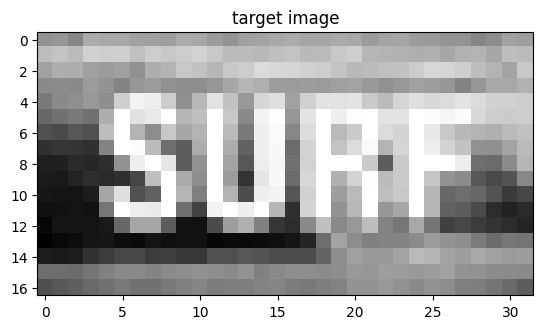

In [12]:
img_input_path = "../images/SURF-600px.jpg"
target_image_path = "../images/output.png"
image_resize(img_input_path, target_image_path, width=32)
image_grayscale(target_image_path, target_image_path)

# Image matrix
image = image_pixel_matrix(target_image_path)
print(image)

print(" width: " + str(len(image[0])) + " height: " + str(len(image)))

plt.imshow(image, cmap='gray')
plt.title('target image')
plt.show()

Step 2: flattening image into vector (for convenience). Calculation of sufficient nuber of qubits.

In [13]:
input_im = image.copy().flatten()
thetas = np.interp(input_im, (0, 256), (0, np.pi/2))
coord_q_num = int(np.ceil(math.log(len(input_im), 2)))

Step 3: quantum circuit building.

In [14]:
O = QuantumRegister(coord_q_num, 'coordinates')
c = QuantumRegister(1,'c_reg')
cr = ClassicalRegister(O.size+c.size, "cl_reg")

qc_image = QuantumCircuit(c, O, cr)
num_qubits = qc_image.num_qubits
input_im = image.copy().flatten()
qc_image.id(c)
qc_image.h(O)

controls_ = []
for i, _ in enumerate(O):
    controls_.extend([O[i]])

for i, theta in enumerate(thetas):
    qubit_index_bin = "{0:b}".format(i).zfill(coord_q_num)
    
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
            
    # qc_image.barrier()
    # for coord_or_intns in (0,1):
    qc_image.mcry(theta=2*theta,
                  q_controls=controls_,
                  q_target=c[0])

    # qc_image.barrier()
    for k, qub_ind in enumerate(qubit_index_bin):
        if int(qub_ind):
            qc_image.x(O[k])
           
    # qc_image.barrier()

qc_image.measure(list(reversed(range(qc_image.num_qubits))), list(range(cr.size)))

Metrics

| Image size  | Depth measure | # of utilized qubits |Washington depth | IonQ depth |
| ------------- | ------------- | -------------------|-----------------|------------|
| 2  | 20  | 3 | 211| 98|
| 4  | 467  | 5 | 2776| 962|
| 8  | 8003  | 7 | 49404| 16130|
| 16  | 130307  | 9 | |260351|
| 32  | 2094083  | 11|
| 64  | -  | 13 |
| 128  | -  | 15 |
| 256  | -  | 17 |

In [15]:
print("depth is {}, # of qubits is {}".format(qc_image.depth(), qc_image.num_qubits))

depth is 4871, # of qubits is 11


In [16]:
print(len(coupling_map[0]))
cm = transpiler.CouplingMap(couplinglist=coupling_map[0], description="washington-qc coupling map")
wash_qc = transpile(circuits=qc_image, coupling_map=cm, basis_gates=basis_gates)
print("depth is {}".format(wash_qc.depth()))
#wash_qc.draw()

55
depth is 151236


Circuit drawing

Step 4: quantum circuit execution, measurments' interpretation

In [26]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc_image = transpile(qc_image, aer_sim)
# job_oqim = aer_sim.run(qobj)
job_oqim = aer_sim.run(t_qc_image, shots=20000)
result_oqim = job_oqim.result()
counts_oqim = result_oqim.get_counts()
classical_colors = []
for i in range(0, len(input_im)):
    color_list = []
    for item in counts_oqim.items():
        key = item[0]
        amount = item[1]
        bin_coord = key[1:]
        int_coord = int(bin_coord, 2)
        if int_coord == i:
            color_list.append((key[0], amount))
    color_amount = 0
    for color, amount in color_list:
        if not int(color):
            color_amount=color_amount+amount
    try:
        color = np.arccos((color_amount/sum(n for _, n in color_list))**(1/2))
        classical_colors.append(color)
    except ZeroDivisionError:
        print("ZeroDivisionError")
classical_colors = list(reversed(np.interp(classical_colors, (0, np.pi/2), (0, 256)).astype(int)))
print(classical_colors, '\n', input_im)

[np.int64(165), np.int64(151), np.int64(110), np.int64(141), np.int64(175), np.int64(172), np.int64(180), np.int64(152), np.int64(176), np.int64(183), np.int64(149), np.int64(166), np.int64(152), np.int64(160), np.int64(134), np.int64(206), np.int64(158), np.int64(167), np.int64(164), np.int64(151), np.int64(146), np.int64(148), np.int64(180), np.int64(168), np.int64(175), np.int64(192), np.int64(174), np.int64(139), np.int64(160), np.int64(190), np.int64(159), np.int64(158), np.int64(106), np.int64(102), np.int64(128), np.int64(103), np.int64(120), np.int64(162), np.int64(187), np.int64(113), np.int64(167), np.int64(164), np.int64(160), np.int64(159), np.int64(153), np.int64(107), np.int64(150), np.int64(177), np.int64(167), np.int64(162), np.int64(165), np.int64(176), np.int64(164), np.int64(164), np.int64(202), np.int64(180), np.int64(151), np.int64(200), np.int64(172), np.int64(192), np.int64(128), np.int64(158), np.int64(138), np.int64(109), np.int64(0), np.int64(0), np.int64(0), 

Input and measured images comparison

In [27]:
def plot_to_compare(output_im, input_im):
    plt.imshow(output_im, cmap = 'gray')
    plt.title('measured image')
    plt.show()
    plt.imshow(input_im, cmap = 'gray')
    plt.title('real image')
    plt.show()

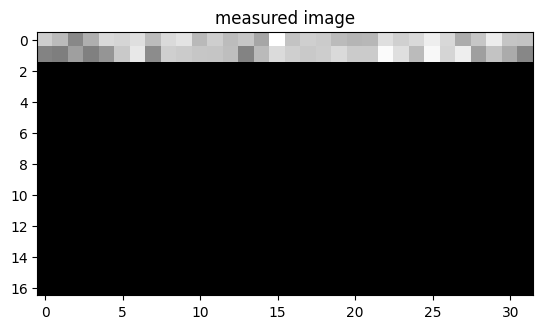

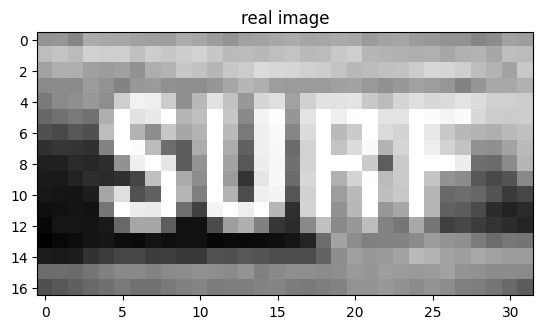

(17, 32)


In [31]:
plot_to_compare(np.array(classical_colors).reshape(image.shape), image)